### [Manifolds](https://scikit-learn.org/stable/modules/manifold.html)
- An approach to non-linear dimensionality reduction (DR) tasks.
- Basic idea: in many cases, data dimensionality is *artificially* high - which adds to  visualization difficulty.
- The simplest method is by taking a *random projection* of the data. This may aid visualization, but you're likely losing interesting structures within the data.
- **Manifold learning** is an extension of *linear* DR techniques (ex: PCA) to *nonlinear* data.

### [Example: DR technique comparison - Digits dataset](https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html#sphx-glr-auto-examples-manifold-plot-lle-digits-py)

In [1]:
from time import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection, neighbors)

In [2]:
digits = datasets.load_digits(n_class=6)
X,y = digits.data, digits.target
n_samples, n_features = X.shape
n_neighbors = 30

In [3]:
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            
            if np.min(dist) < 4e-3:
                continue # don't show points that are too close
                
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox     = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], 
                                      cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
            
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

Text(0.5, 1.0, 'From the 64-D digits dataset')

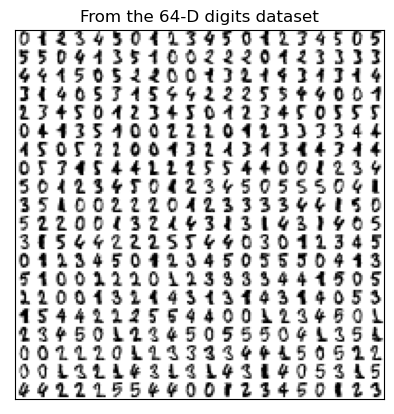

In [4]:
# Plot images of the digits
n_img_per_row = 20
img           = np.zeros((10*n_img_per_row, 
                          10*n_img_per_row))

for i in range(n_img_per_row):
    ix = 10*i+1
    for j in range(n_img_per_row):
        iy = 10*j+1
        img[ix:ix + 8, 
            iy:iy + 8] = X[i * n_img_per_row + j].reshape((8, 8))

plt.imshow(img, cmap=plt.cm.binary)
plt.xticks([]); plt.yticks([]); plt.title('From the 64-D digits dataset')


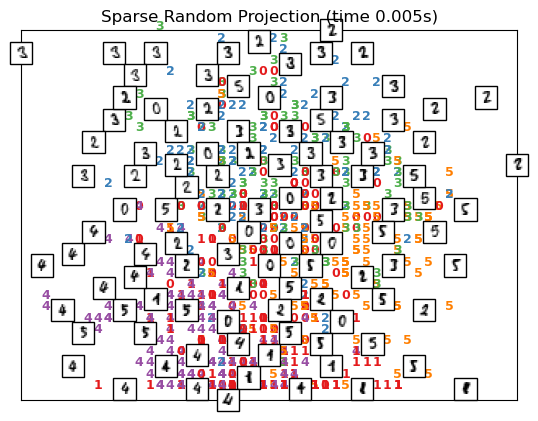

In [5]:
t0 = time()
rp = random_projection.SparseRandomProjection(n_components=2, random_state=42)
X_projected = rp.fit_transform(X)
plot_embedding(X_projected, "Sparse Random Projection (time %.3fs)" % (time()-t0))

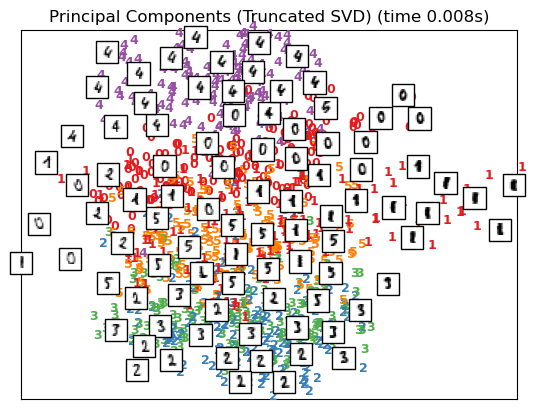

In [6]:
t0 = time()
X_pca = decomposition.TruncatedSVD(n_components=2).fit_transform(X)
plot_embedding(X_pca,
               "Principal Components (Truncated SVD) (time %.3fs)" %
               (time() - t0))

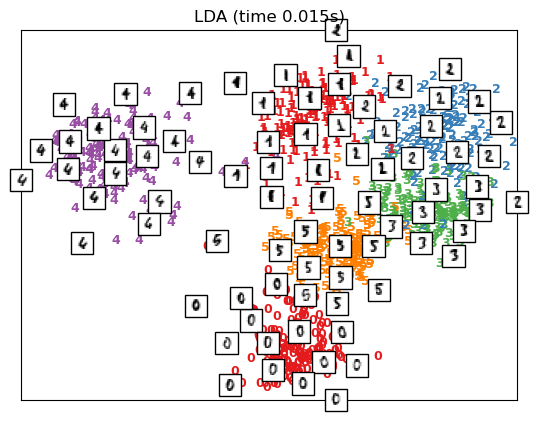

In [8]:
X2 = X.copy(); X2.flat[::X.shape[1] + 1] += 0.01  # Make X invertible
t0 = time()
X_lda = discriminant_analysis.LinearDiscriminantAnalysis(n_components=2).fit_transform(X2, y)
plot_embedding(X_lda, "LDA (time %.3fs)" % (time() - t0))

### [Isomap](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.Isomap.html#sklearn.manifold.Isomap) (Isometric Mapping)
- Can be viewed an extension of MDS (Multi-dimensional Scaling) or Kernel PCA.
- Isomap finds a lower-D embedding which *maintains geodesic distances between all points.*
- Three algorithm steps:
    - **Nearest neighbor search** using a BallTree.
    - **Shortest-path graph search**: `path_method` selects either *Dijkstra's* or *Floyd-Warshall* algorithm. The code chooses a method, based on the dataset, if not specified.
    - **Partial eigenvalue decomposition**: 
        - The embedded model is stored in the eigenvectors corresponding to the $d$ largest eigenvalues of the $NxN$ isomap kernel.
        - `eigen_solver` controls the solver method & looks for a best method, based on the data, if not specified. The computation cost can be improved if `ARPACK` is used.

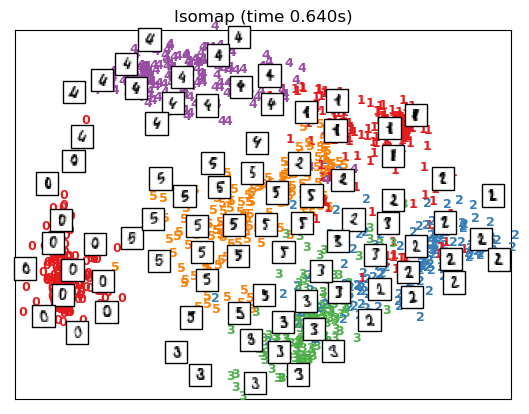

In [9]:
t0 = time()
X_iso = manifold.Isomap(n_neighbors=n_neighbors, n_components=2).fit_transform(X)
plot_embedding(X_iso, "Isomap (time %.3fs)" % (time() - t0))

### [Locally Linear Embedding](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.LocallyLinearEmbedding.html#sklearn.manifold.LocallyLinearEmbedding) (LLE)
- Finds a lower-D data projection while *preserving distances between local neighborhoods*. 
- Algorithm description:
    - **Nearest neighbor search**: same as above.
    - **Local neighborhood weight matrix construction**: $kxk$, for each of $N$ local neighborhoods.
    - **Partial eigenvalue decomposition**: same as above.

Reconstruction error: 1.75239e-06


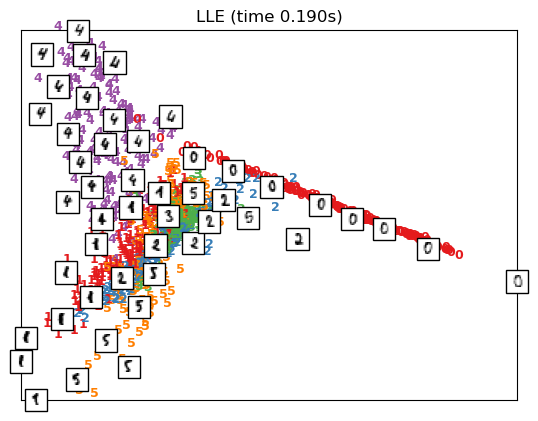

In [11]:
clf = manifold.LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=2,
                                      method='standard')
t0 = time()
X_lle = clf.fit_transform(X)
plot_embedding(X_lle, "LLE (time %.3fs)" % (time() - t0))
print("Reconstruction error: %g" % clf.reconstruction_error_)

### [Modified LLE (MLLE)](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.LocallyLinearEmbedding.html#sklearn.manifold.LocallyLinearEmbedding)
- LLE's problem is with regularization - if #neighbors > #dimensions, then matrix that defines each local neighborhood is [rank deficient](https://en.wikipedia.org/wiki/Rank_(linear_algebra). 
- Standard LLE solves this with a regularization parameter $r$ which is chosen due to the *trace of the local weight matrix* (def?). The solution *should* converge to a desired embedding as r->0, but there's no guarantee that it will do so. This can result in distortions.
- MLLE uses *multiple weight vectors* in each neighborhood to overcome this weakness.
- `method="modified"` controls this feature. It requires `n_neighbors` > `n_components`.
- Algorithm description:
    - **Nearest neighbor search**: same as above.
    - **Local neighborhood weight matrix construction**: similar to above, except for adding the weight matrix from multiple weights.
    - **Partial eigenvalue decomposition**: same as above.

Reconstruction error: 0.361282


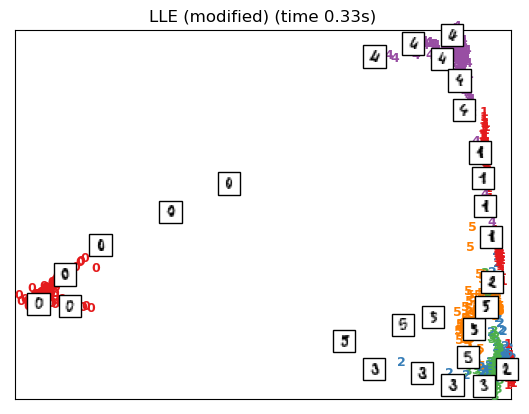

In [12]:
clf = manifold.LocallyLinearEmbedding(
    n_neighbors=n_neighbors, n_components=2, method='modified')
t0 = time()
X_mlle = clf.fit_transform(X)
plot_embedding(X_mlle, "LLE (modified) (time %.2fs)" % (time() - t0))
print("Reconstruction error: %g" % clf.reconstruction_error_)

### [Hessian-based LLE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.LocallyLinearEmbedding.html#sklearn.manifold.LocallyLinearEmbedding)
- Another method of solving the LLE regularization problem.
- Uses a *hessian-based quadratic form* at each neighborhood to recover locally linear structures.
- `method="hessian"` controls this feature. It requires `n_neighbors` > `n_components*(n_components+3)/2`.
- Algorithm description:
    - **Nearest neighbor search**: same as above.
    - **Local neighborhood weight matrix construction**: similar to standard LLE, plus a *QR decomposition* of a local Hessian estimator.
    - **Partial eigenvalue decomposition**: same as above.

Reconstruction error: 0.212688


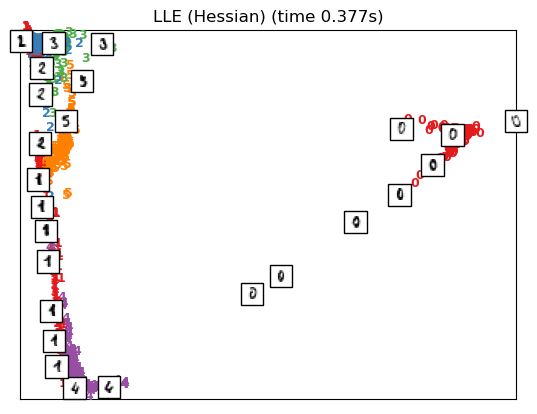

In [13]:
clf = manifold.LocallyLinearEmbedding(
    n_neighbors=n_neighbors, n_components=2, method='hessian')
t0 = time()
X_hlle = clf.fit_transform(X)
plot_embedding(X_hlle, "LLE (Hessian) (time %.3fs)" %
               (time() - t0))
print("Reconstruction error: %g" % clf.reconstruction_error_)

### [Local Tangent Space Alignment (LTSA)](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.LocallyLinearEmbedding.html#sklearn.manifold.LocallyLinearEmbedding)
- [reference (2004)](http://citeseer.ist.psu.edu/viewdoc/summary?doi=10.1.1.4.3693)
- Algorithmically similar to LLE, but technically not a variant.
- LTSA finds a description of each neighborhood geometry via its [tangent space](https://en.wikipedia.org/wiki/Tangent_space)
- Aligns local tangent spaces to learn the low-D embedding.
- Algorithm description:
    - **Nearest neighbor search**: same as above.
    - **Weight matrix construction**: (TBD)
    - **Partial eigenvalue decomposition**: same as above.

Reconstruction error: 0.212713


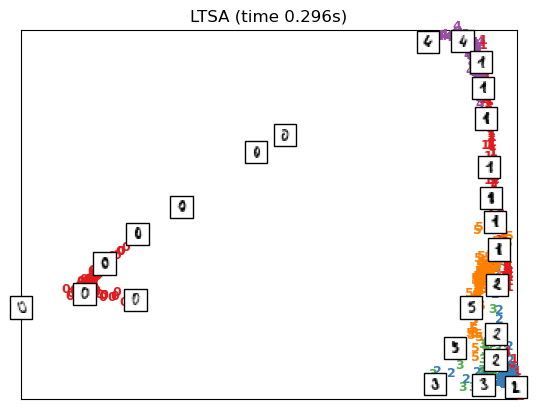

In [14]:
clf = manifold.LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=2, method='ltsa')
t0 = time()
X_ltsa = clf.fit_transform(X)
plot_embedding(X_ltsa, "LTSA (time %.3fs)" % (time() - t0))
print("Reconstruction error: %g" % clf.reconstruction_error_)


### [Multi-dimensional Scaling (MDS)](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html#sklearn.manifold.MDS)
- [wikipedia](https://en.wikipedia.org/wiki/Multidimensional_scaling)
- Technique for analyzing data similarity. Models similarity as distances in geometric space. Data can be ratings, interaction frequencies, or other similar indices.
- $S$ is the similarity matrix; $X$ = input coordinates of $n$ points. The *disparities* ($\hat{d}_{ij}$) are transforms of the similarities, chosen in an optimal manner.
- The objective (aka "**stress**") is defined as $\sum_{i < j} d_{ij}(X) - \hat{d}_{ij}(X)$.
- Two variants:
    - **metric**: distances between two output points are set to as close together as possible to the similarity metric. (def?)
    - **non-metric**: algorithm tries to preserve order of distances - therefore looks for a *monotonic relation* between the embedded-space distances.

Stress: 172287710.368707


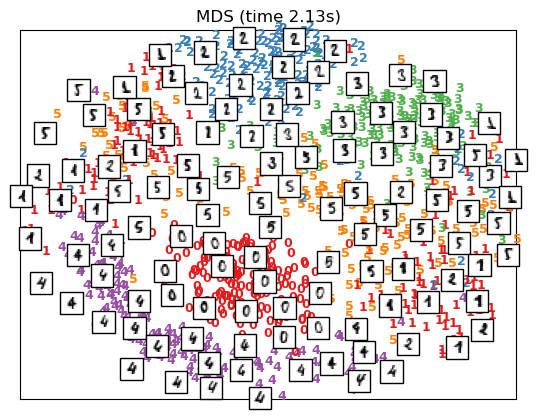

In [16]:
clf = manifold.MDS(n_components=2, n_init=1, max_iter=100, normalized_stress='auto')
t0 = time()
X_mds = clf.fit_transform(X)
plot_embedding(X_mds, "MDS (time %.2fs)" % (time() - t0))
print("Stress: %f" % clf.stress_)

### [Example: Metric vs Non-Metric MDS](https://scikit-learn.org/stable/auto_examples/manifold/plot_mds.html)

In [17]:
# metric vs non-metric MDS - reconstructed points on noisy data
# (plots slightly shifted to avoid complete overlap)

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
from sklearn import manifold
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA

In [18]:
EPSILON      = np.finfo(np.float32).eps
n_samples    = 20
seed         = np.random.RandomState(seed=3)
X_true       = seed.randint(0, 20, 2 * n_samples).astype(float)
X_true       = X_true.reshape((n_samples, 2))
X_true      -= X_true.mean() # Center the data
similarities = euclidean_distances(X_true)
noise        = np.random.rand(n_samples, n_samples)
noise        = noise + noise.T
noise[np.arange(noise.shape[0]), np.arange(noise.shape[0])] = 0
similarities += noise

In [19]:
mds = manifold.MDS(n_components=2, 
                   max_iter=3000, eps=1e-9, random_state=seed,
                   dissimilarity="precomputed", n_jobs=1)
nmds = manifold.MDS(n_components=2, metric=False, 
                    max_iter=3000, eps=1e-12,
                    dissimilarity="precomputed", 
                    random_state=seed, n_jobs=1, n_init=1)

pos  = mds.fit(similarities).embedding_
npos = nmds.fit_transform(similarities, init=pos)

# Rescale the data
pos  *= np.sqrt((X_true ** 2).sum()) / np.sqrt((pos ** 2).sum())
npos *= np.sqrt((X_true ** 2).sum()) / np.sqrt((npos ** 2).sum())

clf    = PCA(n_components=2) # Rotate the data
X_true = clf.fit_transform(X_true)

pos  = clf.fit_transform(pos)
npos = clf.fit_transform(npos)

/home/bjpcjp/.local/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/bjpcjp/.local/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


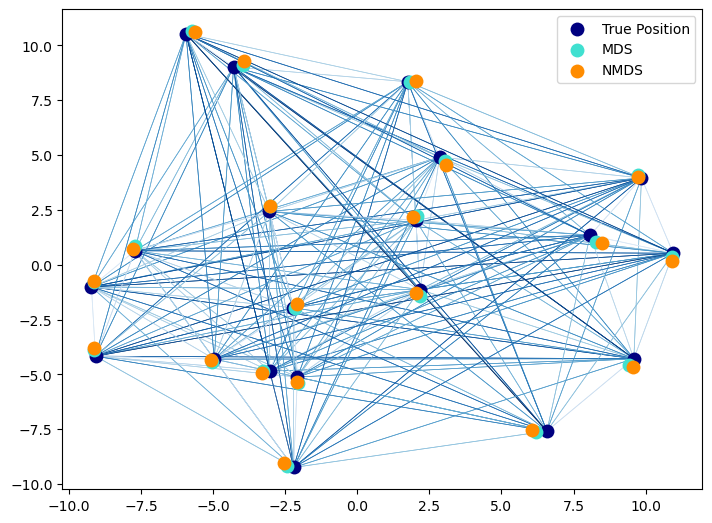

In [21]:
fig = plt.figure(1)
ax = plt.axes([0., 0., 1., 1.])

s = 100
plt.scatter(X_true[:, 0], 
            X_true[:, 1], color='navy', s=s, lw=0,
            label='True Position')
plt.scatter(pos[:, 0], 
            pos[:, 1], color='turquoise', s=s, lw=0, label='MDS')
plt.scatter(npos[:, 0], 
            npos[:, 1], color='darkorange', s=s, lw=0, label='NMDS')

plt.legend(scatterpoints=1, loc='best', shadow=False)

similarities = similarities.max() / (similarities + EPSILON) * 100
np.fill_diagonal(similarities, 0)
# Plot the edges
start_idx, end_idx = np.where(pos)
# a sequence of (*line0*, *line1*, *line2*), where::
#            linen = (x0, y0), (x1, y1), ... (xm, ym)
segments = [[X_true[i, :], X_true[j, :]]
            for i in range(len(pos)) for j in range(len(pos))]

values = np.abs(similarities)

lc = LineCollection(segments,
                    zorder=0, cmap=plt.cm.Blues,
                    norm=plt.Normalize(0, values.max()))

lc.set_array(similarities.flatten())
lc.set_linewidths(np.full(len(segments), 0.5))
ax.add_collection(lc)
plt.show()

### [Random Trees Embedding](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomTreesEmbedding.html?highlight=randomtreesembedding)
- Discussed in the Ensembles section.

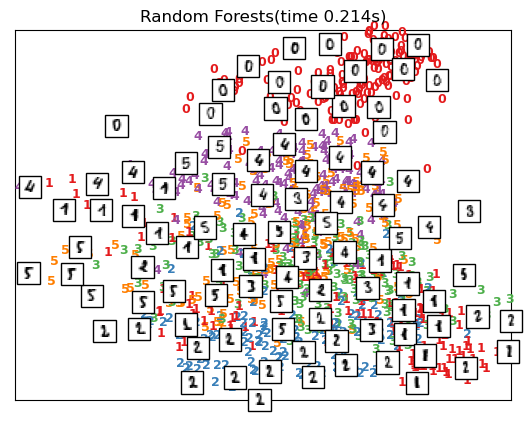

In [22]:
hasher = ensemble.RandomTreesEmbedding(n_estimators=200, random_state=0,
                                       max_depth=5)
t0 = time()
X_transformed = hasher.fit_transform(X)
pca           = decomposition.TruncatedSVD(n_components=2)
X_reduced     = pca.fit_transform(X_transformed)
plot_embedding(X_reduced, "Random Forests(time %.3fs)" % (time() - t0))

### [Spectral Embedding](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.SpectralEmbedding.html#sklearn.manifold.SpectralEmbedding)
- [reference (2003)](https://web.cse.ohio-state.edu/~mbelkin/papers/LEM_NC_03.pdf)
- Scikit-learn uses a [Laplacian eigenmap](https://www.cs.cmu.edu/~aarti/Class/10701/slides/Lecture21_1.pdf) to build the low-D representation. Minimizing the graph's cost function forces points close to each other retain their "closeness" in the low-D representation.
- Algorithm description:
    - **Weighted graph construction**: transform the raw data into a graph model using an *affinity (adjacency)* matrix representation.
    - **Graph Laplacian construction**: ($N$ = #training points, $D$ = input dimensions, $k$ = #nearest neighbors, $d$ = output dimensions)
        - not normalized: $L$ = $D$-$A$
        - normalized: $L = D^{-\frac{1}{2}} (D-A) D^{-\frac{1}{2}}$
    - **Partial eigenvalue decomposition**: done on the graph Laplacian.

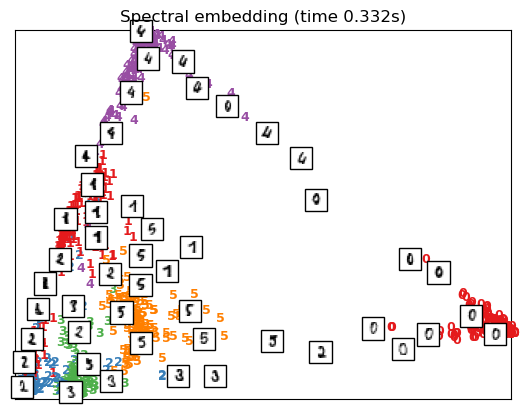

In [23]:
embedder = manifold.SpectralEmbedding(n_components=2, random_state=0,
                                      eigen_solver="arpack")
t0 = time()
X_se = embedder.fit_transform(X)
plot_embedding(X_se, "Spectral embedding (time %.3fs)" % (time() - t0))

### [t-distributed Stochastic Neighbor Embedding (t-SNE)](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html#sklearn.manifold.TSNE)
- [Best practices tips (distill.pub)](https://distill.pub/2016/misread-tsne/)
- Converts affinities to probabilities. 
- Original-space affinities are represented by *Gaussian joint probabilities*.
- Embedded affinities are represented by *Student-t distributions*.
- Allows t-SNE to be *sensitive to local structures*.
- Gradient descent is used to minimize the [Kullback-Leibler (KL) divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) of the joint probabilities. KL divergence with different starting points will end up in local minima - use multiple seeds & select an embedding with the lowest KL divergence.
- *Computationally expensive*.
- The *Barnes-Hut t-SNE method* is limited to 2-3 dimensional embeddings.
- Global structure is not preserved - this problem can be mitigated by initializing points with PCA (`init="PCA"`).

- Key parameters:
    - *perplexity*: The perplexity of a k-sided die is k = effectively the number of nearest neighbors t-SNE considers when generating the conditional probabilities. Larger perplexities lead to more nearest neighbors and is less sensitive to small structure. Lower perplexities consider a smaller number of neighbors, and thus ignores more global information in favour of the local neighborhood. 
    
    As dataset sizes get larger more points will be required to get a reasonable sample of the local neighborhood - larger perplexities may be required. Noisier datasets will require larger perplexity values to encompass enough local neighbors to see beyond the background noise.
    
    - *early exaggeration factor*: During early exaggeration the original joint probabilities will be artificially increased by multiplication with a given factor. Larger factors result in larger gaps between natural clusters. If the factor is too high, the KL divergence could increase during this phase. Usually it does not have to be tuned.
    
    - *learning rate*: If it is too low, gradient descent will get stuck in a bad local minimum. If it is too high, the KL divergence will increase during optimization.
    
    - *max #iterations*: usually high enough and does not need any tuning. 
    
    - *angle*: a tradeoff between performance and accuracy. Larger angles imply that we can approximate larger regions by a single point, leading to better speed but less accurate results.

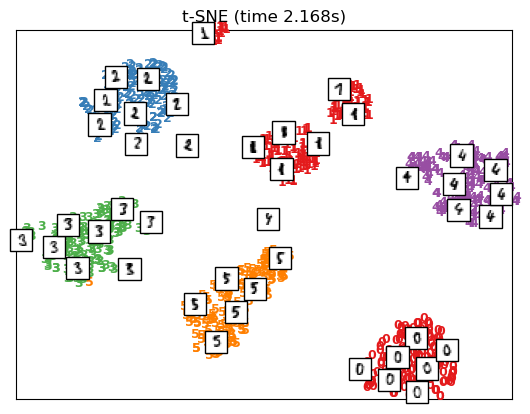

In [24]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
t0 = time()
X_tsne = tsne.fit_transform(X)
plot_embedding(X_tsne, "t-SNE (time %.3fs)" % (time() - t0))

### [Neighborhood Components Analysis (NCA)](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NeighborhoodComponentsAnalysis.html?highlight=neighborhoodcomponentsanalysis#sklearn.neighbors.NeighborhoodComponentsAnalysis)
- Defined in Nearest Neighbors section. 
- Learns a linear transform to improve classification accuracy.

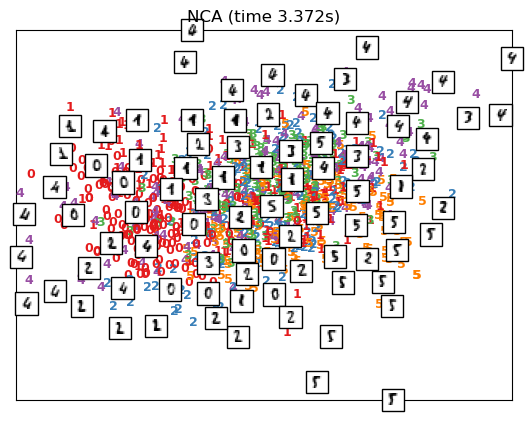

In [25]:
nca = neighbors.NeighborhoodComponentsAnalysis(init='random',
                                               n_components=2, random_state=0)
t0 = time()
X_nca = nca.fit_transform(X, y)
plot_embedding(X_nca, "NCA (time %.3fs)" % (time() - t0))